<a href="https://colab.research.google.com/github/hjaelee01/AIFFEL_quest_rs/blob/main/KaKr_Housing_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_data_path = join('./drive/MyDrive', 'train.csv')
sub_data_path = join('./drive/MyDrive', 'test.csv')
print(train_data_path, sub_data_path)

./drive/MyDrive/train.csv ./drive/MyDrive/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [ ]:
# data와 sub 변수에 csv 파일 저장.
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
# data와 sub의 차원
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6555, 20)


Kaggle submission file은 6468개의 row가 있어야 하는데, 현재 sub data에는 6555개의 row가 있어서 87개의 row를 제거해줘야 합니다.

In [ ]:
sub = sub.iloc[:-87]

# data와 sub의 차원
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


train data와 sub data 간에 feature 수의 차이가 있다. train data에만 있고 sub data엔 없는 feature가 무엇인지 확인합니다.

In [ ]:
list(set(data.columns)-set(sub.columns))

['price']

In [ ]:
# data 미리보기
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


우리가 예측해야 하는 y값인 `price` column은 `y`변수에 따로 저장해주고, 원래의 `data`에서는 제거해줍니다.  
결국 `data`는 y값을 제외한 모든 column을 포함합니다.

In [ ]:
y = data['price']

del data['price']

In [ ]:
y.shape

(15035,)

`data`를 훈련용 데이터셋과 테스트용 데이터셋을 합친 전체 데이터셋으로 설정합니다.  
기존의 훈련용 데이터셋인 `data`의 길이는 `train_len`에 저장합니다.

In [ ]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [ ]:
print(data.shape)
data.head()

(21503, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 bar함수를 사용해 결측치가 있는 feature가 있는지 한눈에 확인할 수 있습니다.

<Axes: >

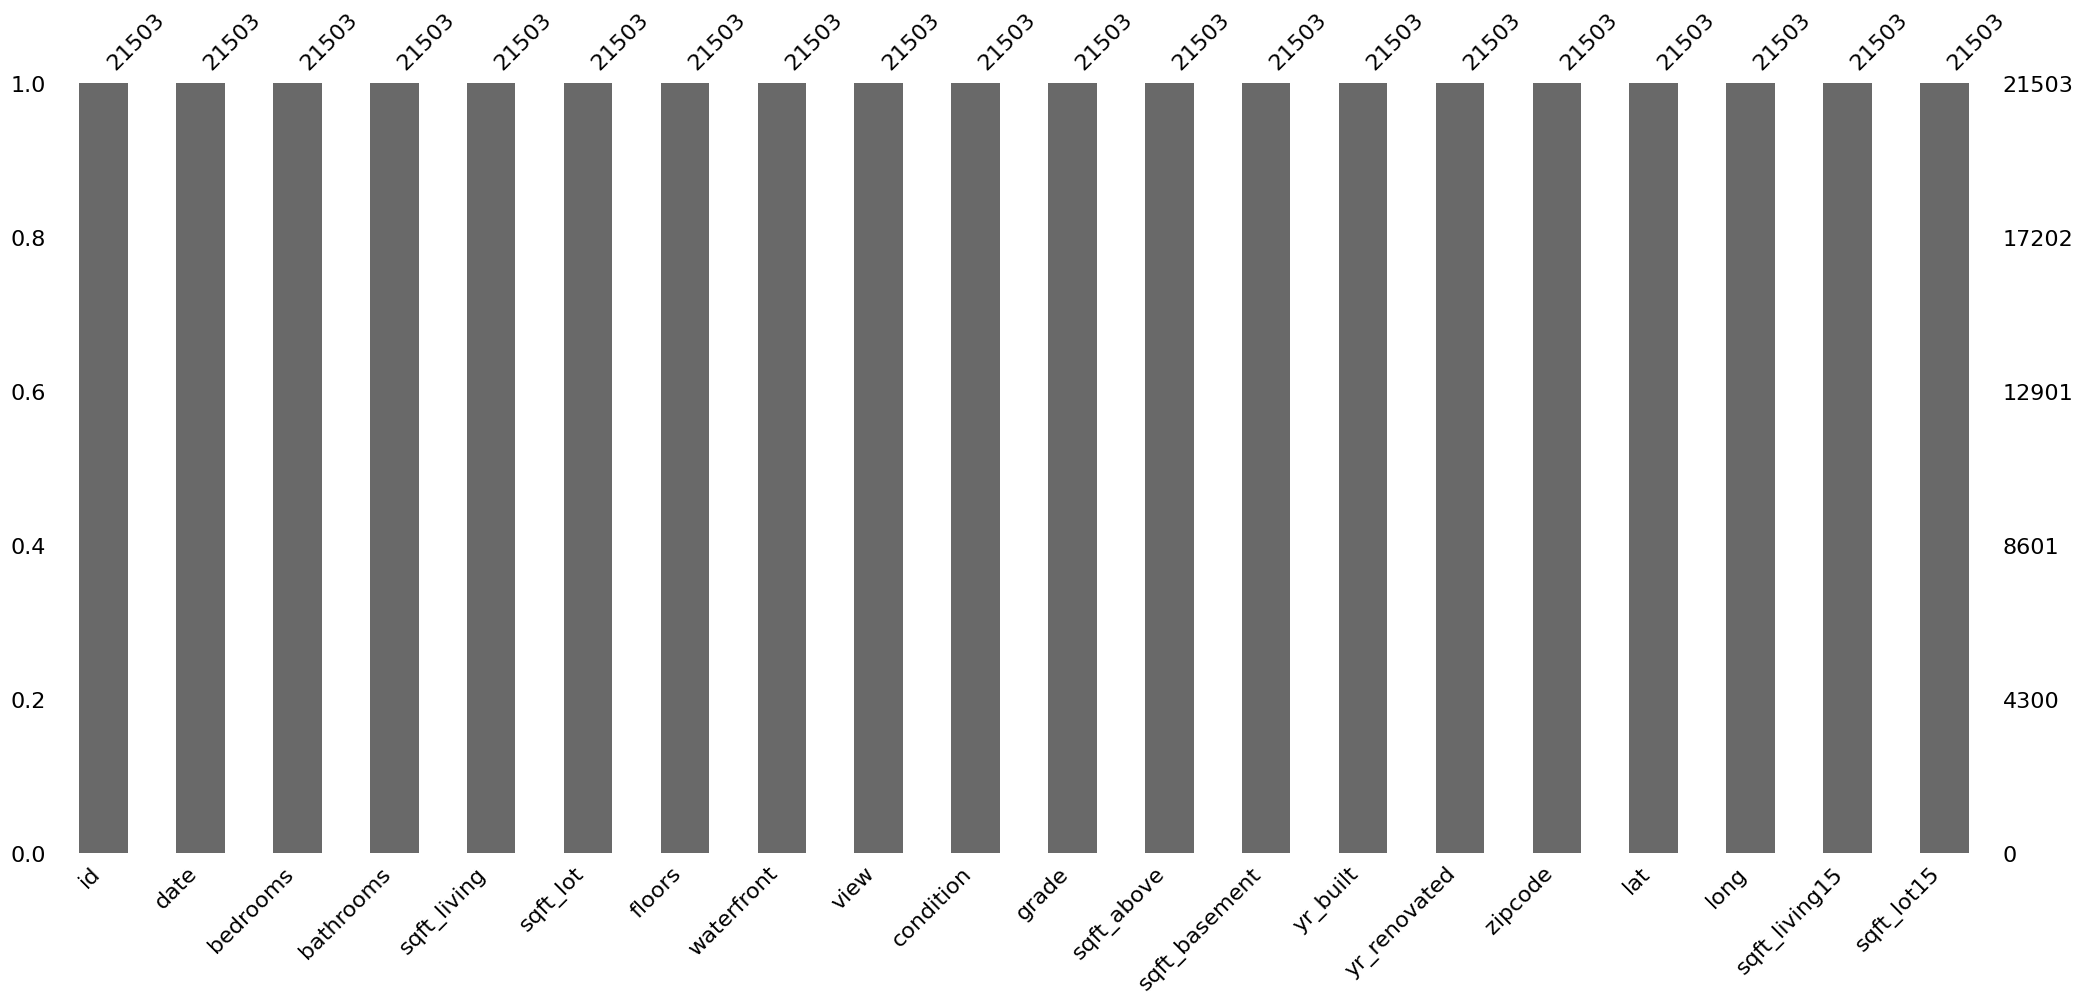

In [ ]:
msno.bar(data)

### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

data의 각 feature의 자료형을 보며 inf, float이나 bool이 아닌 자료형이 있는지 확인합니다.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_living1

date column은 object 자료형임을 확인할 수 있습니다.  
이를 모델이 인식하기 편하게끔 앞의 4자리수는 data['year']에, 그 뒤의 2자리는 data['month']에 저장해줍니다.

In [ ]:
sub_id = data['id'][train_len:]
del data['id']

data['year'] = data['date'].str[:4].astype(int)
data['month'] = data['date'].str[4:6].astype(int)
del data['date']

print(data.shape)
data.head()

(21503, 20)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
2,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2
3,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,2014,6
4,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,2015,1


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

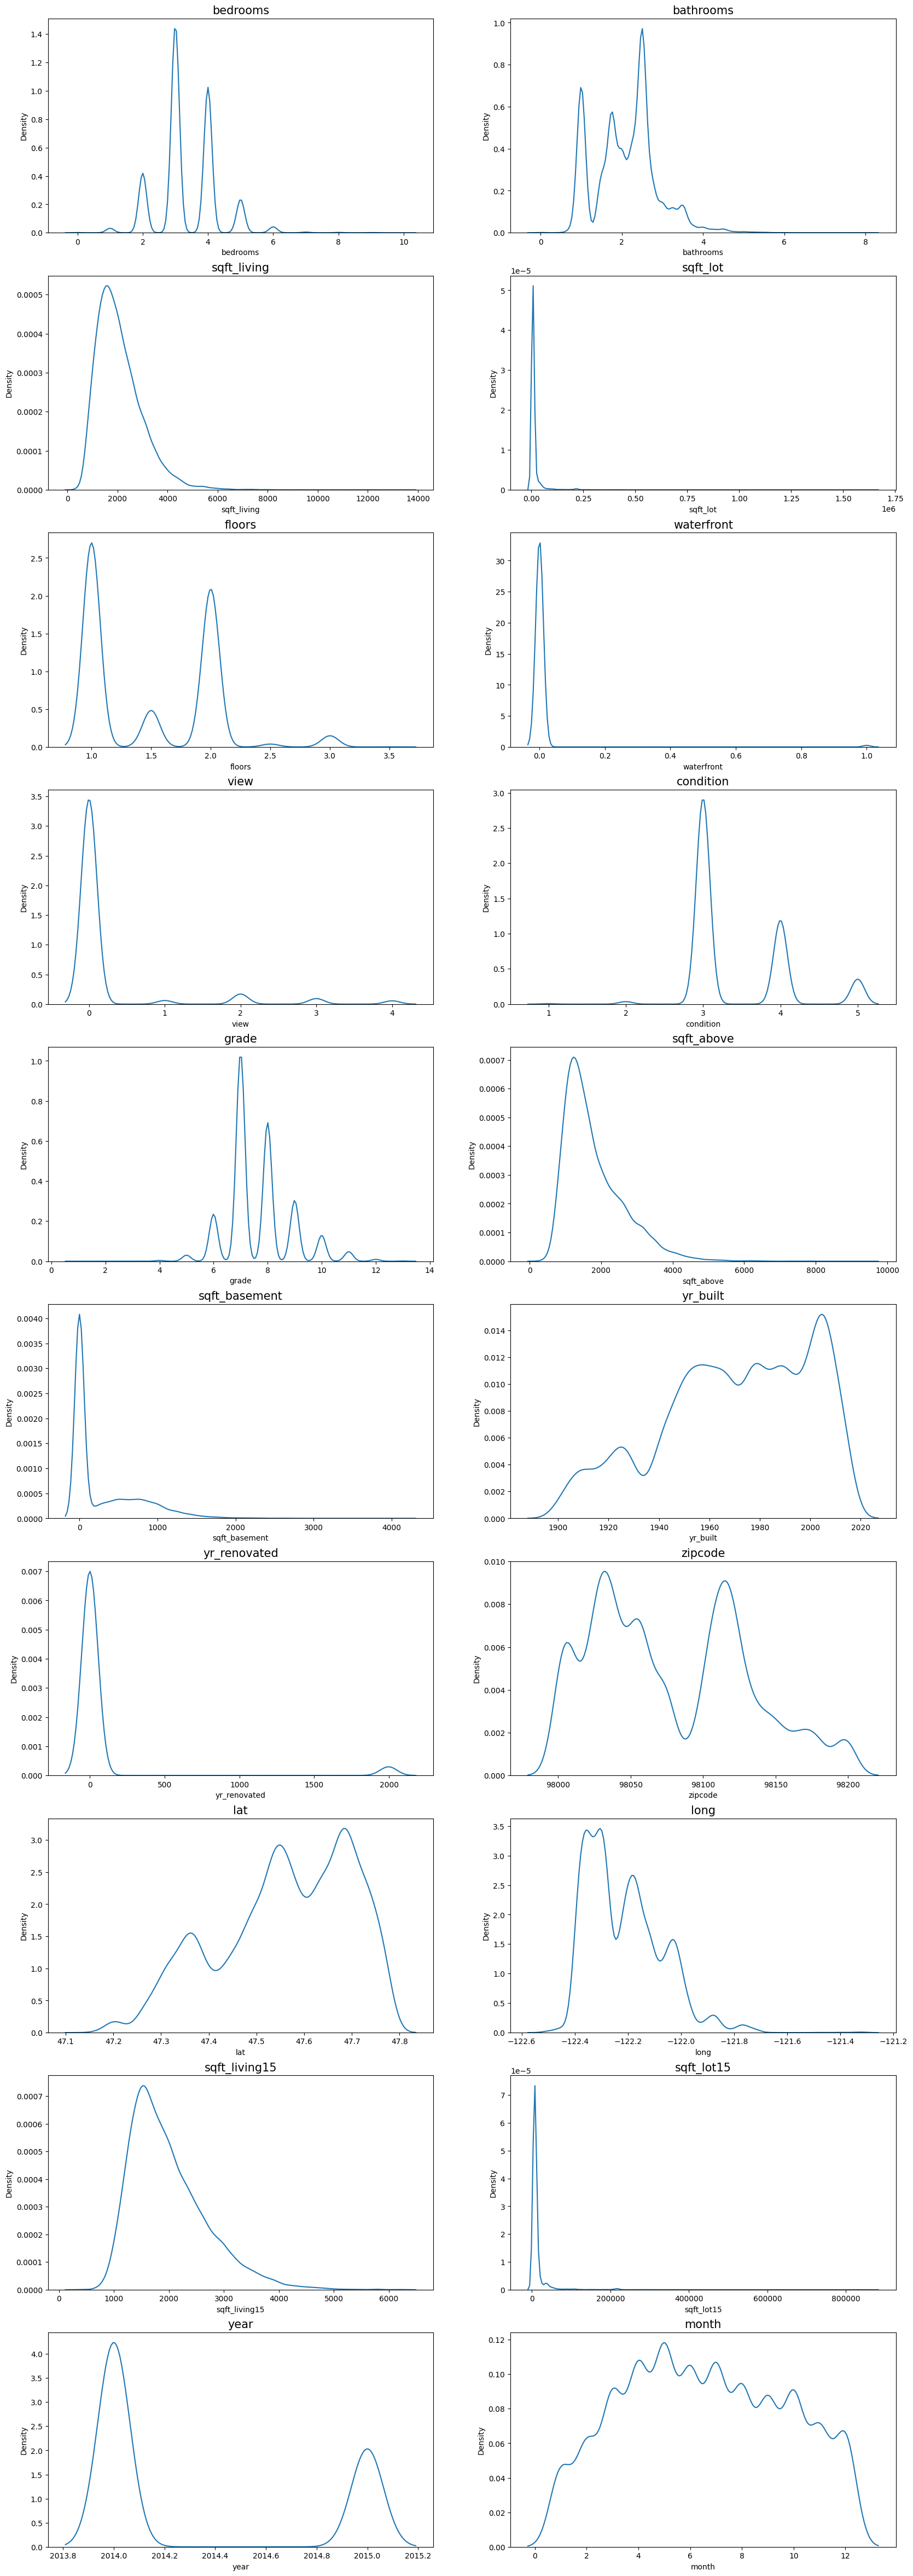

In [ ]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 20 :
            break

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [ ]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

skew_columns들이 제대로 정규화되었는지 그래프로 시각화해서 비교해 봅시다.

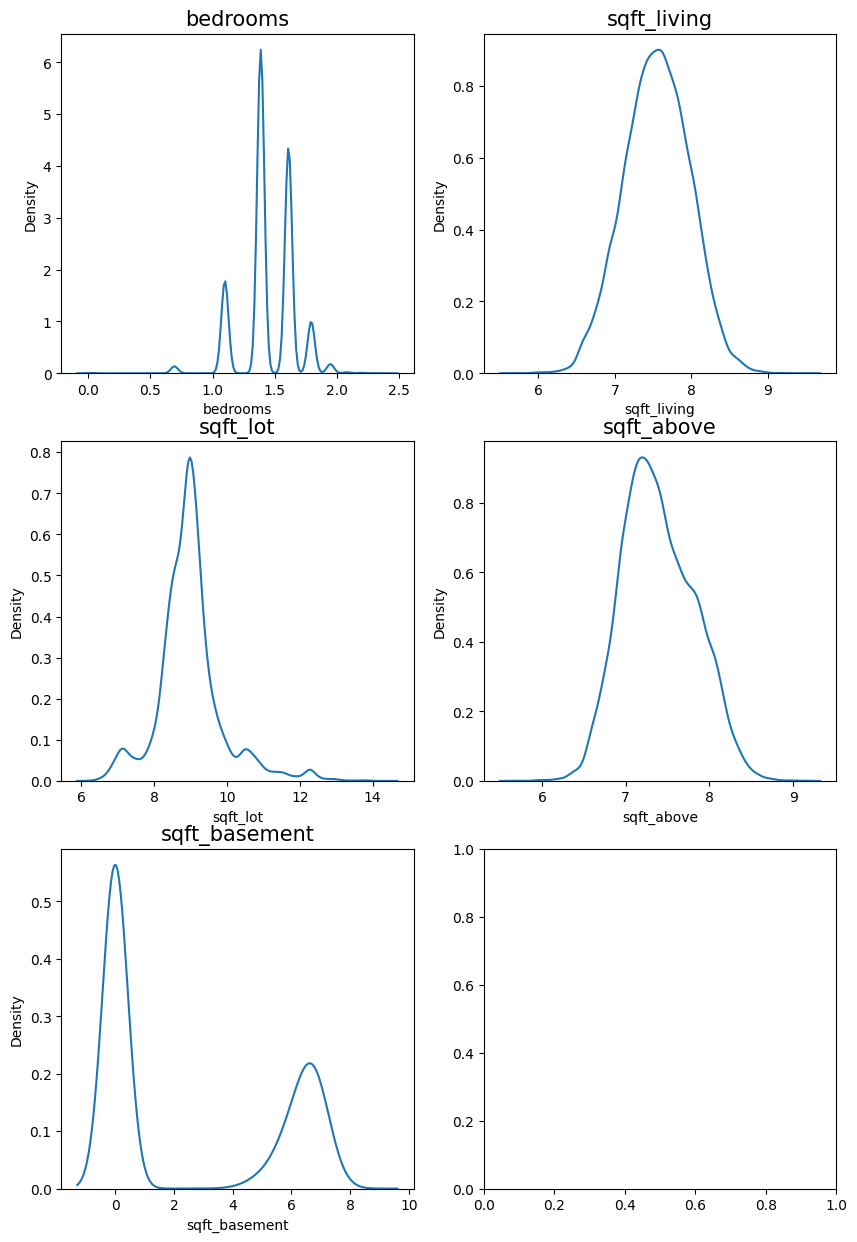

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.



In [ ]:
# 전체 데이터를 훈련용, 테스트용으로 다시 나눠주기
# x: training data
# sub: test data
x = data.iloc[:train_len, :]
sub = data.iloc[train_len:, :]

# x와 sub의 차원을 프린트해서 제대로 나뉘어졌는지 확인
print(x.shape, sub.shape)

(15035, 20) (6468, 20)


## 3. 모델 실험
여러 모델들과 하이퍼 파라미터 조합을 실험하여 rmse 값을 최소화시킬 방법을 찾습니다.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
random_state = 2025

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

models list에 있는 model의 rmse값을 비교하는 함수 get_scores를 만듭니다.

In [ ]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = np.sqrt(mean_squared_error(y_pred, y_test))

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return df

# models에 저장된 모델들 각각의 rmse값 확인
get_scores(models, x, y);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 20
[LightGBM] [Info] Start training from score 538846.072414


같은 데이터로 훈련했을 때 GradientBoostingRegressor, XGBRegressor, LGBMRegressor, RandomForestRegressor 순으로 퍼포먼스가 좋습니다.  
RandomForestRegressor, LGBM, XGB, GB 순으로 실험하며 rmse값이 좋아지는지 보겠습니다.

In [ ]:
# 모델마다 각각의 param_grid 설정
models = {
    'rf': {'model': rdforest, 'param_grid': {
                                'n_estimators': [50, 75, 100],
                                'max_depth': [1, 5, 8, 10],
                              }
          },
    'lgbm': {'model': lightgbm, 'param_grid': {
                                'n_estimators': [50, 75, 100],
                                'max_depth': [1, 5, 8, 10],
                                'num_leaves': [2, 20, 100, 600],
                                'learning_rate': [0.001, 0.1, 1],
                              }
          },
    'xgb': {'model': xgboost, 'param_grid': {
                                'n_estimators': [50, 75, 100],
                                'max_depth': [1, 5, 8, 10],
                                'learning_rate': [0.001, 0.1, 1],
                              }},
    'gb': {'model': gboost, 'param_grid': {
                                'n_estimators': [50, 75, 100],
                                'max_depth': [1, 5, 8, 10],
                                'learning_rate': [0.001, 0.1, 1],
                              }},
}


각 모델의 최적의 hyper-parameter 조합을 찾아낼 `my_GridSearch`함수를 만들어줍니다.

In [ ]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    print(results)

    best_model = grid_model.best_estimator_
    return best_model

### RandomForestRegressor

In [ ]:
opt_rdforest = my_GridSearch(rdforest, x, y, param_grid=models['rf']['param_grid'], verbose=2, n_jobs=-1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
   max_depth  n_estimators         score          RMSLE
7         10           100 -1.966120e+10  140218.411764
6         10            50 -1.983473e+10  140835.840162
5          8           100 -2.213192e+10  148768.017947
4          8            50 -2.216946e+10  148894.136082
3          5           100 -3.135198e+10  177064.909344
2          5            50 -3.163639e+10  177866.227281
1          1           100 -8.548155e+10  292372.288136
0          1            50 -8.629680e+10  293763.163200


RandomForestRegressor 모델을 훈련시킨 결과 입력한 param_grid에서 최적의 조합은   
max_depth: 10,  
n_estimators: 100
으로 확인됩니다.

n_estimators와는 상관없이 max_depth가 높을 수록 RMSLE값이 작은 걸 보니  
max_depth가 가장 중요한 parameter로 보입니다.

### LGBMRegressor

In [ ]:
opt_lightgbm = my_GridSearch(lightgbm, x, y, param_grid=models['lgbm']['param_grid'], verbose=2, n_jobs=-1)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2340
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 20
[LightGBM] [Info] Start training from score 540682.653143
    learning_rate  max_depth  n_estimators  num_leaves         score  \
61          0.100         10           100          20 -1.639429e+10   
53          0.100          8           100          20 -1.658561e+10   
62          0.100         10           100         100 -1.679173e+10   
63          0.100         10           100         600 -1.705587e+10   
58          0.100         10            50         100 -1.707178e+10   
..            ...        ...           ...         ...           ...   
8           0.001      

LGMRegressor 모델을 훈련시킨 결과 입력한 param_grid에서 최적의 조합은  
learning_rate: 0.1,  
max_depth: 10,  
n_estimators: 100,  
num_leaves: 20  
으로 확인됩니다.

### XGBRegressor

In [ ]:
opt_xgboost = my_GridSearch(xgboost, x, y, param_grid=models['xgb']['param_grid'], verbose=2, n_jobs=-1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
    learning_rate  max_depth  n_estimators         score          RMSLE
11          0.100          5           100 -1.717241e+10  131043.539092
13          0.100          8           100 -1.727882e+10  131448.932612
12          0.100          8            50 -1.804571e+10  134334.329646
15          0.100         10           100 -1.843003e+10  135757.234787
14          0.100         10            50 -1.881838e+10  137180.099565
10          0.100          5            50 -1.898042e+10  137769.445790
18          1.000          5            50 -2.806357e+10  167521.838676
19          1.000          5           100 -2.884786e+10  169846.565465
17          1.000          1           100 -3.073938e+10  175326.489102
20          1.000          8            50 -3.268393e+10  180786.976532
21          1.000          8           100 -3.295935e+10  181547.104712
22          1.000         10            50 -3.341585e+10  182800.040748
23

### GradientBoostRegressor

In [ ]:
opt_gboost = my_GridSearch(gboost, x, y, param_grid=models['gb']['param_grid'], verbose=2, n_jobs=-1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
    learning_rate  max_depth  n_estimators         score          RMSLE
11          0.100          5           100 -1.547709e+10  124406.957106
13          0.100          8           100 -1.577837e+10  125611.981537
12          0.100          8            50 -1.635035e+10  127868.476795
10          0.100          5            50 -1.701092e+10  130425.936643
15          0.100         10           100 -1.805221e+10  134358.513780
14          0.100         10            50 -1.830061e+10  135279.762698
17          1.000          1           100 -3.120563e+10  176651.149536
18          1.000          5            50 -3.368439e+10  183533.084501
16          1.000          1            50 -3.449389e+10  185725.299723
19          1.000          5           100 -3.520746e+10  187636.514710
9           0.100          1           100 -3.732412e+10  193194.505798
20          1.000          8            50 -3.892644e+10  197297.845315
21

## 4. Ensemble
### Average Blending으로 최적화

In [ ]:

import numpy as np
def AveragingBlending(models, X_train, y_train, X_test):
    for m in models :
        m['model'].fit(X_train, y_train)

    predictions = np.column_stack([
        m['model'].predict(X_test) for m in models
    ])
    return np.mean(predictions, axis=1)



In [ ]:
sub.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,4760,101930,2014,5
1,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,2390,7570,2015,3
2,1.609438,3.00,7.989899,8.517393,2.0,0,3,3,9,7.591357,6.878326,1979,0,98126,47.5714,-122.375,2140,4000,2015,1
3,1.098612,1.00,7.090910,9.195328,1.0,0,0,4,7,7.090910,0.000000,1921,0,98002,47.3089,-122.210,1060,5095,2014,12
4,1.609438,1.75,7.390799,8.513386,1.0,0,0,4,7,6.758095,6.634633,1947,0,98133,47.7025,-122.341,1400,4980,2014,5


In [ ]:
x.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
2,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2
3,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,6819,2014,6
4,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9711,2015,1


In [ ]:
# 하이퍼파라미터가 최적화된 모델 리스트
opt_models = [
    {'model': opt_rdforest, 'name': 'RandomForest'},
    {'model': opt_lightgbm, 'name': 'LightGBM'},
    {'model': opt_xgboost, 'name': 'XGBoost'},
    {'model': opt_gboost, 'name': 'GradientBoosting'},
]
  # [opt_rdforest, opt_lightgbm, opt_xgboost, opt_gboost]


y_pred = AveragingBlending(opt_models, x, y, sub)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2340
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 20
[LightGBM] [Info] Start training from score 540682.653143


In [ ]:
x.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
2,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2
3,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,6819,2014,6
4,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9711,2015,1


### Cross Validation으로 opt_models 평가

In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2025).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y))))

In [ ]:
get_cv_score(opt_models)

Model RandomForest CV score : 0.8570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 20
[LightGBM] [Info] Start training from score 540497.991270
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2329
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 20
[LightGBM] [Info] Start training from score 542956.681826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the over

최적화된 모델들의 cross_val_score가 0.8570, 0.8811, 0.8756, 0.8870으로 꽤 정확한 모습을 보입니다.  
이제 Kaggle에 제출하기 위해 sub 파일을 만들겠습니다.

In [ ]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub

,id,price
0,15208,1.390847e+06
1,15209,3.155168e+05
2,15210,8.330796e+05
3,15211,2.206903e+05
4,15212,4.394379e+05
...,...,...
6463,21671,6.998318e+05
6464,21672,3.231283e+05
6465,21673,2.920474e+05
6466,21674,3.782190e+05


In [ ]:
sub.to_csv('submission.csv', index=False)